In [1]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

import datetime  # For datetime objects
import os.path  # To manage paths
import sys  # To find out the script name (in argv[0])

# Import the backtrader platform
import backtrader as bt
import pyfolio as pf
import matplotlib
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

/home/aviral/Desktop/Algo_trading_iitk/env/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal
/home/aviral/Desktop/Algo_trading_iitk/env/lib/python3.7/site-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; mutltipliers will not be applied' +


In [2]:
class TestStrategy(bt.Strategy):
    
    params = dict(profit_percent=0.3, loss_percent = 0.2, efast = 10, eslow=30)
    
    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        tm = self.datas[0].datetime.time(0)
        print('%s, %s,  %s' % (dt.isoformat(), tm.isoformat(), txt))

    def __init__(self):
        self.dataclose = self.datas[0].close
        self.time = self.datas[0].datetime.time
        self.order = None
        self.price = None
        self.comm = None
        emafast = bt.ind.EMA(period=self.p.efast)
        emaslow = bt.ind.EMA(period=self.p.eslow)
        self.crossover = bt.ind.CrossOver(emafast,emaslow)
        
    def notify_order(self, order):
        date = self.data.datetime.datetime().date()
        
        if order.status in [order.Submitted, order.Accepted]:
            return
            
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))

                self.price = order.executed.price
                self.comm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

            self.bar_executed = len(self)

        elif order.status in [order.Margin, order.Rejected]:
            self.log('Order Margin/Rejected')
        
        elif order.status in [order.Canceled]:
            self.log('Order Canceled')
            #Closing Bracket orders comes under this condition

        self.order = None
        
    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))
                 
    def next(self):
        #self.log('Close, %.2f' % self.dataclose[0])

        if self.order:
            return
        
        #adding the 15 minute buffer
        if (self.data.datetime.time() < datetime.time(9,30)) or (self.data.datetime.time() > datetime.time(15,15)):
            return
        
        if not self.position:
            #Check the order while placing the amounts for different types, limit order and to do functions
            #like find a breakout and confirm the indicator. Many a times generates errors
            if self.crossover>0:
                self.log('BUY CREATE, %.2f' % self.dataclose[0])
                entry = self.dataclose
                self.order = self.buy_bracket(limitprice=entry*(1+(self.p.profit_percent/100)),
                                              stopprice=entry*(1-(self.p.loss_percent/100)),
                                              exectype=bt.Order.Market)

        #Uncomment this and find that it is buying and selling way too frequently.
        #The behavior can be observed from the plot but no explanation
        else:
            if self.crossover<0:
                self.log('SELL CREATE, %.2f' % self.dataclose[0])
                entry = self.dataclose
                self.order = self.sell_bracket(limitprice=entry*(1-(self.p.profit_percent/100)),
                                              stopprice=entry*(1+(self.p.loss_percent/100)),
                                              exectype=bt.Order.Market)

        

In [3]:
#A function for properly processing and printing analyzers
def printTradeAnalysis(analyzer):
    
    #Get the results we are interested in
    total_open = analyzer.total.open
    total_closed = analyzer.total.closed
    total_won = analyzer.won.total
    total_lost = analyzer.lost.total
    win_streak = analyzer.streak.won.longest
    lose_streak = analyzer.streak.lost.longest
    pnl_net = round(analyzer.pnl.net.total,2)
    strike_rate = (total_won / total_closed) * 100
    
    #Designate the rows
    h1 = ['Total Open', 'Total Closed', 'Total Won', 'Total Lost']
    h2 = ['Strike Rate','Win Streak', 'Losing Streak', 'PnL Net']
    r1 = [total_open, total_closed,total_won,total_lost]
    r2 = [strike_rate, win_streak, lose_streak, pnl_net]
    #Check which set of headers is the longest.
    if len(h1) > len(h2):
        header_length = len(h1)
    else:
        header_length = len(h2)
    #Print the rows
    
    print_list = [h1,r1,h2,r2]
    row_format ="{:<15}" * (header_length + 1)
    print("\n\nTrade Analysis Results:")
    for row in print_list:
        print(row_format.format('',*row))

In [11]:
if __name__ == '__main__':
    cerebro = bt.Cerebro()
    cerebro.addstrategy(TestStrategy)

    # Datas are in a subfolder of the samples. Need to find where the script is
    # because it could have been called from anywhere
    #modpath = os.path.dirname(os.path.abspath(sys.argv[0]))
    #datapath = os.path.join(modpath, 'datas/orcl-1995-2014.txt')
    dirpath = os.path.dirname('/home/aviral/Desktop/Algo_trading_iitk/')
    datapath = os.path.join(dirpath, 'Nifty_2013.csv')

    #Check the format and positions of the datafeeds in case another file is used
    data = bt.feeds.GenericCSVData(
        dataname=datapath,
        
        #Even though the data file has 2013 in name, the data is actually of 2015
        fromdate=datetime.datetime(2015, 1, 1),
        todate=datetime.datetime(2015, 12, 31),
        nullvalue = 0.0,
        
        dtformat = ('%d/%m/%Y'),
        tmformat = ('%H:%M:%S'),
        
        timeframe = bt.TimeFrame.Minutes,
        compression = 1,
        #Compression is useful if the data is per minute but we want to use 5 min intervals
                
        datetime = 0,
        time = 1,
        open = 2,
        high = 3,
        low = 4,
        close = 5,
        volume = 6,
        openinterest = -1,
        reverse=False)

    cerebro.adddata(data)
    cerebro.broker.setcash(100000.0)

    cerebro.addsizer(bt.sizers.FixedSize, stake=2)
    
    cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="ta")
    cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='mysharpe')
    cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')

    cerebro.broker.setcommission(commission=0.001)

    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
    strats = cerebro.run()
    printTradeAnalysis(strats[0].analyzers.ta.get_analysis())

    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
    
    #A weird error, scroll down and check. After september 8th all orders are displaying margin/cancelled


Starting Portfolio Value: 100000.00
2015-01-01, 10:38:00,  BUY CREATE, 8315.15
2015-01-01, 10:39:00,  BUY EXECUTED, Price: 8315.15, Cost: 16630.30, Comm 16.63
2015-01-01, 10:44:00,  SELL CREATE, 8313.90
2015-01-01, 10:45:00,  SELL EXECUTED, Price: 8313.90, Cost: 16630.30, Comm 16.63
2015-01-01, 10:45:00,  OPERATION PROFIT, GROSS -2.50, NET -35.76
2015-01-01, 10:47:00,  BUY CREATE, 8315.40
2015-01-01, 10:48:00,  BUY EXECUTED, Price: 8315.40, Cost: 16630.80, Comm 16.63
2015-01-01, 12:19:00,  SELL CREATE, 8323.70
2015-01-01, 12:20:00,  SELL EXECUTED, Price: 8323.70, Cost: 16630.80, Comm 16.65
2015-01-01, 12:20:00,  OPERATION PROFIT, GROSS 16.60, NET -16.68
2015-01-01, 12:54:00,  BUY CREATE, 8323.00
2015-01-01, 12:55:00,  BUY EXECUTED, Price: 8323.00, Cost: 16646.00, Comm 16.65
2015-01-01, 12:57:00,  SELL CREATE, 8319.50
2015-01-01, 12:58:00,  SELL EXECUTED, Price: 8319.50, Cost: 16646.00, Comm 16.64
2015-01-01, 12:58:00,  OPERATION PROFIT, GROSS -7.00, NET -40.28
2015-01-01, 12:58:00,  BU

2015-01-06, 11:58:00,  SELL EXECUTED, Price: 8241.95, Cost: 16488.00, Comm 16.48
2015-01-06, 11:58:00,  OPERATION PROFIT, GROSS -4.10, NET -37.07
2015-01-06, 12:11:00,  SELL EXECUTED, Price: 8227.51, Cost: -16455.02, Comm 16.46
2015-01-06, 12:11:00,  Order Canceled
2015-01-06, 12:50:00,  SELL CREATE, 8231.05
2015-01-06, 12:51:00,  SELL EXECUTED, Price: 8231.05, Cost: -16462.10, Comm 16.46
2015-01-06, 13:06:00,  SELL CREATE, 8234.00
2015-01-06, 13:07:00,  SELL EXECUTED, Price: 8234.00, Cost: -16468.00, Comm 16.47
2015-01-06, 13:16:00,  BUY EXECUTED, Price: 8247.51, Cost: -16461.71, Comm 16.50
2015-01-06, 13:16:00,  Order Canceled
2015-01-06, 13:16:00,  BUY EXECUTED, Price: 8250.47, Cost: -16461.71, Comm 16.50
2015-01-06, 13:16:00,  Order Canceled
2015-01-06, 13:44:00,  SELL CREATE, 8239.45
2015-01-06, 13:45:00,  SELL EXECUTED, Price: 8239.45, Cost: -16478.90, Comm 16.48
2015-01-06, 13:57:00,  BUY EXECUTED, Price: 8255.93, Cost: -16470.30, Comm 16.51
2015-01-06, 13:57:00,  Order Canceled

2015-01-09, 14:48:00,  SELL EXECUTED, Price: 8280.77, Cost: 16512.00, Comm 16.56
2015-01-09, 14:48:00,  Order Canceled
2015-01-09, 14:48:00,  OPERATION PROFIT, GROSS 49.54, NET 16.46
2015-01-12, 09:46:00,  BUY CREATE, 8295.30
2015-01-12, 09:47:00,  BUY EXECUTED, Price: 8296.00, Cost: 16592.00, Comm 16.59
2015-01-12, 10:02:00,  SELL EXECUTED, Price: 8320.19, Cost: 16592.00, Comm 16.64
2015-01-12, 10:02:00,  Order Canceled
2015-01-12, 10:02:00,  OPERATION PROFIT, GROSS 48.37, NET 15.14
2015-01-12, 11:25:00,  BUY CREATE, 8309.75
2015-01-12, 11:26:00,  BUY EXECUTED, Price: 8309.75, Cost: 16619.50, Comm 16.62
2015-01-12, 11:41:00,  SELL CREATE, 8305.55
2015-01-12, 11:42:00,  SELL EXECUTED, Price: 8306.00, Cost: 16619.50, Comm 16.61
2015-01-12, 11:42:00,  OPERATION PROFIT, GROSS -7.50, NET -40.73
2015-01-12, 11:57:00,  BUY CREATE, 8311.60
2015-01-12, 11:58:00,  BUY EXECUTED, Price: 8312.00, Cost: 16624.00, Comm 16.62
2015-01-12, 12:06:00,  BUY EXECUTED, Price: 8322.16, Cost: 16644.32, Comm 1

2015-01-15, 14:31:00,  SELL EXECUTED, Price: 8532.32, Cost: 17040.19, Comm 17.06
2015-01-15, 14:31:00,  Order Canceled
2015-01-15, 14:31:00,  SELL EXECUTED, Price: 8530.51, Cost: 17040.19, Comm 17.06
2015-01-15, 14:31:00,  Order Canceled
2015-01-15, 14:31:00,  SELL EXECUTED, Price: 8532.57, Cost: 17040.19, Comm 17.07
2015-01-15, 14:31:00,  Order Canceled
2015-01-15, 14:34:00,  SELL EXECUTED, Price: 8540.24, Cost: 17040.19, Comm 17.08
2015-01-15, 14:34:00,  Order Canceled
2015-01-15, 14:34:00,  OPERATION PROFIT, GROSS 110.54, NET -25.89
2015-01-16, 09:46:00,  BUY CREATE, 8501.05
2015-01-16, 09:47:00,  BUY EXECUTED, Price: 8501.05, Cost: 17002.10, Comm 17.00
2015-01-16, 11:00:00,  SELL CREATE, 8508.30
2015-01-16, 11:01:00,  SELL EXECUTED, Price: 8508.30, Cost: 17002.10, Comm 17.02
2015-01-16, 11:01:00,  OPERATION PROFIT, GROSS 14.50, NET -19.52
2015-01-16, 11:08:00,  BUY CREATE, 8515.90
2015-01-16, 11:09:00,  BUY EXECUTED, Price: 8515.90, Cost: 17031.80, Comm 17.03
2015-01-16, 11:35:00, 

2015-01-22, 14:51:00,  SELL CREATE, 8762.50
2015-01-22, 14:52:00,  SELL EXECUTED, Price: 8762.50, Cost: -17525.00, Comm 17.53
2015-01-22, 15:19:00,  BUY EXECUTED, Price: 8780.10, Cost: -17515.24, Comm 17.56
2015-01-22, 15:19:00,  Order Canceled
2015-01-23, 09:16:00,  BUY EXECUTED, Price: 8849.40, Cost: -17515.24, Comm 17.70
2015-01-23, 09:16:00,  Order Canceled
2015-01-23, 09:16:00,  BUY EXECUTED, Price: 8849.40, Cost: -17515.24, Comm 17.70
2015-01-23, 09:16:00,  Order Canceled
2015-01-23, 09:16:00,  OPERATION PROFIT, GROSS -412.08, NET -517.59
2015-01-23, 11:31:00,  BUY CREATE, 8823.75
2015-01-23, 11:32:00,  BUY EXECUTED, Price: 8824.00, Cost: 17648.00, Comm 17.65
2015-01-23, 12:14:00,  SELL CREATE, 8827.60
2015-01-23, 12:15:00,  SELL EXECUTED, Price: 8827.60, Cost: 17648.00, Comm 17.66
2015-01-23, 12:15:00,  OPERATION PROFIT, GROSS 7.20, NET -28.10
2015-01-23, 12:23:00,  BUY CREATE, 8833.55
2015-01-23, 12:24:00,  BUY EXECUTED, Price: 8833.55, Cost: 17667.10, Comm 17.67
2015-01-23, 13

2015-01-30, 15:30:00,  SELL EXECUTED, Price: 8886.58, Cost: 17737.21, Comm 17.77
2015-01-30, 15:30:00,  Order Canceled
2015-01-30, 15:30:00,  SELL EXECUTED, Price: 8889.24, Cost: 17737.21, Comm 17.78
2015-01-30, 15:30:00,  Order Canceled
2015-01-30, 15:30:00,  OPERATION PROFIT, GROSS 77.21, NET 6.18
2015-02-02, 09:53:00,  BUY CREATE, 8847.00
2015-02-02, 09:54:00,  BUY EXECUTED, Price: 8847.00, Cost: 17694.00, Comm 17.69
2015-02-02, 10:11:00,  SELL CREATE, 8840.00
2015-02-02, 10:12:00,  SELL EXECUTED, Price: 8839.30, Cost: 17694.00, Comm 17.68
2015-02-02, 10:12:00,  OPERATION PROFIT, GROSS -15.40, NET -50.77
2015-02-02, 10:33:00,  SELL EXECUTED, Price: 8829.31, Cost: -17658.61, Comm 17.66
2015-02-02, 10:33:00,  Order Canceled
2015-02-02, 10:49:00,  BUY EXECUTED, Price: 8857.68, Cost: -17658.61, Comm 17.72
2015-02-02, 10:49:00,  Order Canceled
2015-02-02, 10:49:00,  OPERATION PROFIT, GROSS -56.75, NET -92.12
2015-02-02, 11:25:00,  BUY CREATE, 8846.05
2015-02-02, 11:26:00,  BUY EXECUTED, 

2015-02-05, 14:33:00,  BUY CREATE, 8873.00
2015-02-05, 14:34:00,  BUY EXECUTED, Price: 8873.00, Cost: 17746.00, Comm 17.75
2015-02-05, 14:36:00,  SELL CREATE, 8867.10
2015-02-05, 14:37:00,  SELL EXECUTED, Price: 8867.10, Cost: 17746.00, Comm 17.73
2015-02-05, 14:37:00,  OPERATION PROFIT, GROSS -11.80, NET -47.28
2015-02-05, 14:39:00,  SELL EXECUTED, Price: 8855.25, Cost: -17710.51, Comm 17.71
2015-02-05, 14:39:00,  Order Canceled
2015-02-05, 14:43:00,  BUY EXECUTED, Price: 8840.50, Cost: -17710.51, Comm 17.68
2015-02-05, 14:43:00,  Order Canceled
2015-02-05, 14:43:00,  OPERATION PROFIT, GROSS 29.51, NET -5.88
2015-02-06, 09:48:00,  BUY CREATE, 8756.00
2015-02-06, 09:49:00,  BUY EXECUTED, Price: 8756.00, Cost: 17512.00, Comm 17.51
2015-02-06, 10:08:00,  SELL CREATE, 8744.95
2015-02-06, 10:09:00,  SELL EXECUTED, Price: 8744.95, Cost: 17512.00, Comm 17.49
2015-02-06, 10:09:00,  OPERATION PROFIT, GROSS -22.10, NET -57.10
2015-02-06, 10:11:00,  SELL EXECUTED, Price: 8738.49, Cost: -17476.98

2015-02-11, 11:32:00,  BUY CREATE, 8649.85
2015-02-11, 11:33:00,  BUY EXECUTED, Price: 8649.85, Cost: 17299.70, Comm 17.30
2015-02-11, 12:05:00,  BUY EXECUTED, Price: 8658.13, Cost: 17316.26, Comm 17.32
2015-02-11, 12:05:00,  Order Canceled
2015-02-11, 12:48:00,  SELL CREATE, 8660.90
2015-02-11, 12:49:00,  SELL EXECUTED, Price: 8660.90, Cost: 17307.98, Comm 17.32
2015-02-11, 13:08:00,  SELL EXECUTED, Price: 8674.95, Cost: 17307.98, Comm 17.35
2015-02-11, 13:08:00,  Order Canceled
2015-02-11, 13:08:00,  SELL EXECUTED, Price: 8675.80, Cost: -17351.60, Comm 17.35
2015-02-11, 13:08:00,  Order Canceled
2015-02-11, 13:08:00,  BUY EXECUTED, Price: 8678.22, Cost: -17351.60, Comm 17.36
2015-02-11, 13:08:00,  Order Canceled
2015-02-11, 13:08:00,  OPERATION PROFIT, GROSS 55.73, NET -13.56
2015-02-11, 13:08:00,  OPERATION PROFIT, GROSS -4.84, NET -39.55
2015-02-11, 13:58:00,  BUY CREATE, 8672.10
2015-02-11, 13:59:00,  BUY EXECUTED, Price: 8672.10, Cost: 17344.20, Comm 17.34
2015-02-11, 14:03:00,  

2015-02-18, 13:17:00,  BUY EXECUTED, Price: 8892.40, Cost: 17784.80, Comm 17.78
2015-02-18, 13:17:00,  Order Canceled
2015-02-18, 13:18:00,  BUY EXECUTED, Price: 8893.45, Cost: 17786.90, Comm 17.79
2015-02-18, 13:18:00,  Order Canceled
2015-02-18, 13:33:00,  SELL CREATE, 8880.00
2015-02-18, 13:34:00,  SELL EXECUTED, Price: 8880.00, Cost: 17772.70, Comm 17.76
2015-02-18, 13:35:00,  SELL EXECUTED, Price: 8861.69, Cost: 17772.70, Comm 17.72
2015-02-18, 13:35:00,  Order Canceled
2015-02-18, 13:36:00,  SELL EXECUTED, Price: 8859.65, Cost: 17772.70, Comm 17.72
2015-02-18, 13:36:00,  Order Canceled
2015-02-18, 13:36:00,  OPERATION PROFIT, GROSS -115.43, NET -221.95
2015-02-18, 13:56:00,  BUY CREATE, 8878.40
2015-02-18, 13:57:00,  BUY EXECUTED, Price: 8878.40, Cost: 17756.80, Comm 17.76
2015-02-18, 14:04:00,  SELL EXECUTED, Price: 8899.82, Cost: 17756.80, Comm 17.80
2015-02-18, 14:04:00,  Order Canceled
2015-02-18, 14:04:00,  BUY EXECUTED, Price: 8897.76, Cost: 17795.52, Comm 17.80
2015-02-18,

2015-02-25, 10:26:00,  BUY CREATE, 8826.75
2015-02-25, 10:27:00,  BUY EXECUTED, Price: 8828.00, Cost: 17656.00, Comm 17.66
2015-02-25, 10:37:00,  SELL CREATE, 8821.75
2015-02-25, 10:38:00,  SELL EXECUTED, Price: 8821.80, Cost: 17656.00, Comm 17.64
2015-02-25, 10:38:00,  OPERATION PROFIT, GROSS -12.40, NET -47.70
2015-02-25, 11:14:00,  BUY CREATE, 8821.50
2015-02-25, 11:15:00,  BUY EXECUTED, Price: 8821.55, Cost: 17643.10, Comm 17.64
2015-02-25, 11:57:00,  SELL CREATE, 8826.00
2015-02-25, 11:58:00,  SELL EXECUTED, Price: 8826.05, Cost: 17643.10, Comm 17.65
2015-02-25, 11:58:00,  OPERATION PROFIT, GROSS 9.00, NET -26.30
2015-02-25, 12:18:00,  BUY CREATE, 8831.00
2015-02-25, 12:19:00,  BUY EXECUTED, Price: 8831.15, Cost: 17662.30, Comm 17.66
2015-02-25, 12:24:00,  SELL CREATE, 8822.85
2015-02-25, 12:25:00,  SELL EXECUTED, Price: 8823.00, Cost: 17662.30, Comm 17.65
2015-02-25, 12:25:00,  OPERATION PROFIT, GROSS -16.30, NET -51.61
2015-02-25, 12:47:00,  BUY CREATE, 8829.00
2015-02-25, 12:48

2015-03-02, 13:44:00,  BUY CREATE, 8857.30
2015-03-02, 13:45:00,  BUY EXECUTED, Price: 8857.30, Cost: 17714.60, Comm 17.71
2015-03-02, 13:46:00,  SELL EXECUTED, Price: 8839.59, Cost: 17714.60, Comm 17.68
2015-03-02, 13:46:00,  Order Canceled
2015-03-02, 13:46:00,  OPERATION PROFIT, GROSS -35.43, NET -70.82
2015-03-02, 14:05:00,  BUY CREATE, 8863.00
2015-03-02, 14:06:00,  BUY EXECUTED, Price: 8863.00, Cost: 17726.00, Comm 17.73
2015-03-02, 14:07:00,  SELL EXECUTED, Price: 8845.27, Cost: 17726.00, Comm 17.69
2015-03-02, 14:07:00,  Order Canceled
2015-03-02, 14:07:00,  OPERATION PROFIT, GROSS -35.45, NET -70.87
2015-03-03, 12:26:00,  BUY CREATE, 8969.85
2015-03-03, 12:27:00,  BUY EXECUTED, Price: 8969.95, Cost: 17939.90, Comm 17.94
2015-03-03, 13:08:00,  SELL CREATE, 8966.00
2015-03-03, 13:09:00,  SELL EXECUTED, Price: 8966.00, Cost: 17939.90, Comm 17.93
2015-03-03, 13:09:00,  OPERATION PROFIT, GROSS -7.90, NET -43.77
2015-03-03, 13:16:00,  SELL EXECUTED, Price: 8951.91, Cost: -17903.82, 

2015-03-06, 13:52:00,  BUY CREATE, 8914.00
2015-03-06, 13:53:00,  BUY EXECUTED, Price: 8914.00, Cost: 17828.00, Comm 17.83
2015-03-06, 13:54:00,  BUY EXECUTED, Price: 8923.71, Cost: 17847.42, Comm 17.85
2015-03-06, 13:54:00,  Order Canceled
2015-03-06, 13:57:00,  SELL EXECUTED, Price: 8941.54, Cost: 17837.71, Comm 17.88
2015-03-06, 13:57:00,  Order Canceled
2015-03-06, 13:57:00,  SELL EXECUTED, Price: 8940.74, Cost: 17837.71, Comm 17.88
2015-03-06, 13:57:00,  Order Canceled
2015-03-06, 13:57:00,  OPERATION PROFIT, GROSS 89.15, NET 17.71
2015-03-06, 14:38:00,  BUY CREATE, 8955.05
2015-03-06, 14:39:00,  BUY EXECUTED, Price: 8954.05, Cost: 17908.10, Comm 17.91
2015-03-06, 14:43:00,  SELL CREATE, 8945.10
2015-03-06, 14:44:00,  SELL EXECUTED, Price: 8945.10, Cost: 17908.10, Comm 17.89
2015-03-06, 14:44:00,  OPERATION PROFIT, GROSS -17.90, NET -53.70
2015-03-06, 14:52:00,  BUY CREATE, 8951.85
2015-03-06, 14:53:00,  BUY EXECUTED, Price: 8951.85, Cost: 17903.70, Comm 17.90
2015-03-06, 14:55:00

2015-03-12, 10:39:00,  BUY CREATE, 8811.80
2015-03-12, 10:40:00,  BUY EXECUTED, Price: 8811.80, Cost: 17623.60, Comm 17.62
2015-03-12, 11:01:00,  SELL CREATE, 8802.00
2015-03-12, 11:02:00,  SELL EXECUTED, Price: 8802.00, Cost: 17623.60, Comm 17.60
2015-03-12, 11:02:00,  OPERATION PROFIT, GROSS -19.60, NET -54.83
2015-03-12, 11:25:00,  BUY CREATE, 8809.65
2015-03-12, 11:26:00,  BUY EXECUTED, Price: 8809.00, Cost: 17618.00, Comm 17.62
2015-03-12, 11:38:00,  SELL CREATE, 8804.65
2015-03-12, 11:39:00,  SELL EXECUTED, Price: 8805.00, Cost: 17618.00, Comm 17.61
2015-03-12, 11:39:00,  OPERATION PROFIT, GROSS -8.00, NET -43.23
2015-03-12, 11:48:00,  BUY CREATE, 8807.40
2015-03-12, 11:49:00,  BUY EXECUTED, Price: 8807.20, Cost: 17614.40, Comm 17.61
2015-03-12, 11:54:00,  SELL CREATE, 8803.75
2015-03-12, 11:55:00,  SELL EXECUTED, Price: 8803.00, Cost: 17614.40, Comm 17.61
2015-03-12, 11:55:00,  OPERATION PROFIT, GROSS -8.40, NET -43.62
2015-03-12, 12:04:00,  SELL EXECUTED, Price: 8794.18, Cost: 

2015-03-18, 11:30:00,  BUY EXECUTED, Price: 8735.34, Cost: 17470.67, Comm 17.47
2015-03-18, 11:30:00,  Order Canceled
2015-03-18, 11:30:00,  BUY EXECUTED, Price: 8735.44, Cost: 17470.87, Comm 17.47
2015-03-18, 11:30:00,  Order Canceled
2015-03-18, 11:48:00,  SELL EXECUTED, Price: 8753.18, Cost: 17461.88, Comm 17.51
2015-03-18, 11:48:00,  Order Canceled
2015-03-18, 11:48:00,  SELL EXECUTED, Price: 8752.18, Cost: 17461.88, Comm 17.50
2015-03-18, 11:48:00,  Order Canceled
2015-03-18, 11:48:00,  SELL EXECUTED, Price: 8748.22, Cost: 17461.88, Comm 17.50
2015-03-18, 11:48:00,  Order Canceled
2015-03-18, 11:48:00,  OPERATION PROFIT, GROSS 121.51, NET 16.61
2015-03-18, 12:33:00,  BUY CREATE, 8752.60
2015-03-18, 12:34:00,  BUY EXECUTED, Price: 8753.10, Cost: 17506.20, Comm 17.51
2015-03-18, 12:47:00,  SELL CREATE, 8745.00
2015-03-18, 12:48:00,  SELL EXECUTED, Price: 8745.00, Cost: 17506.20, Comm 17.49
2015-03-18, 12:48:00,  OPERATION PROFIT, GROSS -16.20, NET -51.20
2015-03-18, 13:12:00,  BUY C

2015-03-23, 15:21:00,  SELL EXECUTED, Price: 8559.10, Cost: -17118.19, Comm 17.12
2015-03-23, 15:21:00,  Order Canceled
2015-03-24, 09:46:00,  BUY EXECUTED, Price: 8588.14, Cost: -17118.19, Comm 17.18
2015-03-24, 09:46:00,  Order Canceled
2015-03-24, 09:46:00,  OPERATION PROFIT, GROSS -58.09, NET -92.38
2015-03-24, 10:50:00,  BUY CREATE, 8596.00
2015-03-24, 10:51:00,  BUY EXECUTED, Price: 8596.00, Cost: 17192.00, Comm 17.19
2015-03-24, 11:34:00,  SELL EXECUTED, Price: 8621.79, Cost: 17192.00, Comm 17.24
2015-03-24, 11:34:00,  Order Canceled
2015-03-24, 11:34:00,  OPERATION PROFIT, GROSS 51.58, NET 17.14
2015-03-24, 12:31:00,  BUY CREATE, 8604.75
2015-03-24, 12:32:00,  BUY EXECUTED, Price: 8604.90, Cost: 17209.80, Comm 17.21
2015-03-24, 12:41:00,  SELL CREATE, 8596.25
2015-03-24, 12:42:00,  SELL EXECUTED, Price: 8596.25, Cost: 17209.80, Comm 17.19
2015-03-24, 12:42:00,  OPERATION PROFIT, GROSS -17.30, NET -51.70
2015-03-24, 13:10:00,  BUY CREATE, 8601.00
2015-03-24, 13:11:00,  BUY EXECU

2015-03-30, 11:04:00,  SELL CREATE, 8474.50
2015-03-30, 11:05:00,  SELL EXECUTED, Price: 8474.50, Cost: 16939.90, Comm 16.95
2015-03-30, 11:05:00,  OPERATION PROFIT, GROSS 9.10, NET -24.79
2015-03-30, 11:27:00,  BUY CREATE, 8479.95
2015-03-30, 11:28:00,  BUY EXECUTED, Price: 8479.05, Cost: 16958.10, Comm 16.96
2015-03-30, 11:31:00,  SELL CREATE, 8474.15
2015-03-30, 11:32:00,  SELL EXECUTED, Price: 8474.15, Cost: 16958.10, Comm 16.95
2015-03-30, 11:32:00,  OPERATION PROFIT, GROSS -9.80, NET -43.71
2015-03-30, 11:35:00,  SELL EXECUTED, Price: 8462.99, Cost: -16925.98, Comm 16.93
2015-03-30, 11:35:00,  Order Canceled
2015-03-30, 12:10:00,  SELL CREATE, 8467.60
2015-03-30, 12:11:00,  SELL EXECUTED, Price: 8468.00, Cost: -16936.00, Comm 16.94
2015-03-30, 12:41:00,  BUY EXECUTED, Price: 8484.54, Cost: -16930.99, Comm 16.97
2015-03-30, 12:41:00,  Order Canceled
2015-03-30, 12:50:00,  BUY EXECUTED, Price: 8491.45, Cost: -16930.99, Comm 16.98
2015-03-30, 12:50:00,  Order Canceled
2015-03-30, 12

2015-04-07, 09:40:00,  SELL CREATE, 8696.55
2015-04-07, 09:41:00,  SELL EXECUTED, Price: 8696.95, Cost: -17393.90, Comm 17.39
2015-04-07, 10:25:00,  SELL CREATE, 8697.50
2015-04-07, 10:26:00,  SELL EXECUTED, Price: 8697.50, Cost: -17395.00, Comm 17.39
2015-04-07, 11:01:00,  BUY EXECUTED, Price: 8671.41, Cost: -17301.20, Comm 17.34
2015-04-07, 11:01:00,  Order Canceled
2015-04-07, 11:03:00,  BUY EXECUTED, Price: 8670.46, Cost: -17301.20, Comm 17.34
2015-04-07, 11:03:00,  Order Canceled
2015-04-07, 12:06:00,  SELL CREATE, 8673.00
2015-04-07, 12:07:00,  SELL EXECUTED, Price: 8672.95, Cost: -17345.90, Comm 17.35
2015-04-07, 12:13:00,  BUY EXECUTED, Price: 8646.98, Cost: -17316.10, Comm 17.29
2015-04-07, 12:13:00,  Order Canceled
2015-04-07, 13:14:00,  SELL CREATE, 8637.90
2015-04-07, 13:15:00,  SELL EXECUTED, Price: 8637.85, Cost: -17275.70, Comm 17.28
2015-04-07, 13:26:00,  SELL CREATE, 8633.00
2015-04-07, 13:27:00,  SELL EXECUTED, Price: 8634.00, Cost: -17268.00, Comm 17.27
2015-04-07, 1

2015-04-16, 12:05:00,  SELL CREATE, 8726.55
2015-04-16, 12:06:00,  SELL EXECUTED, Price: 8726.55, Cost: -17453.10, Comm 17.45
2015-04-16, 12:33:00,  BUY EXECUTED, Price: 8700.37, Cost: -17616.82, Comm 17.40
2015-04-16, 12:33:00,  Order Canceled
2015-04-16, 14:07:00,  SELL CREATE, 8699.90
2015-04-16, 14:08:00,  SELL EXECUTED, Price: 8699.90, Cost: -17399.80, Comm 17.40
2015-04-16, 14:37:00,  BUY EXECUTED, Price: 8717.30, Cost: -17544.48, Comm 17.43
2015-04-16, 14:37:00,  Order Canceled
2015-04-17, 10:58:00,  SELL CREATE, 8679.80
2015-04-17, 10:59:00,  SELL EXECUTED, Price: 8680.00, Cost: -17360.00, Comm 17.36
2015-04-17, 11:01:00,  BUY EXECUTED, Price: 8697.16, Cost: -17482.99, Comm 17.39
2015-04-17, 11:01:00,  Order Canceled
2015-04-17, 11:34:00,  SELL CREATE, 8690.05
2015-04-17, 11:35:00,  SELL EXECUTED, Price: 8690.05, Cost: -17380.10, Comm 17.38
2015-04-17, 12:53:00,  SELL CREATE, 8685.30
2015-04-17, 12:54:00,  SELL EXECUTED, Price: 8685.30, Cost: -17370.60, Comm 17.37
2015-04-17, 1

2015-04-27, 13:23:00,  SELL CREATE, 8262.00
2015-04-27, 13:24:00,  SELL EXECUTED, Price: 8262.05, Cost: -16524.10, Comm 16.52
2015-04-27, 13:36:00,  BUY EXECUTED, Price: 8249.18, Cost: -16630.00, Comm 16.50
2015-04-27, 13:36:00,  Order Canceled
2015-04-27, 13:53:00,  SELL CREATE, 8258.90
2015-04-27, 13:54:00,  SELL EXECUTED, Price: 8258.00, Cost: -16516.00, Comm 16.52
2015-04-27, 14:03:00,  BUY EXECUTED, Price: 8237.21, Cost: -16601.50, Comm 16.47
2015-04-27, 14:03:00,  Order Canceled
2015-04-27, 14:03:00,  BUY EXECUTED, Price: 8234.12, Cost: -16601.50, Comm 16.47
2015-04-27, 14:03:00,  Order Canceled
2015-04-27, 14:50:00,  SELL CREATE, 8240.25
2015-04-27, 14:51:00,  SELL EXECUTED, Price: 8240.25, Cost: -16480.50, Comm 16.48
2015-04-27, 15:07:00,  BUY EXECUTED, Price: 8215.53, Cost: -16561.17, Comm 16.43
2015-04-27, 15:07:00,  Order Canceled
2015-04-28, 10:48:00,  SELL CREATE, 8253.05
2015-04-28, 10:49:00,  SELL EXECUTED, Price: 8253.10, Cost: -16506.20, Comm 16.51
2015-04-28, 11:24:00

2015-05-07, 11:37:00,  SELL CREATE, 8100.00
2015-05-07, 11:38:00,  SELL EXECUTED, Price: 8100.00, Cost: -16200.00, Comm 16.20
2015-05-07, 11:39:00,  BUY EXECUTED, Price: 8088.76, Cost: -16271.52, Comm 16.18
2015-05-07, 11:39:00,  Order Canceled
2015-05-07, 12:18:00,  BUY EXECUTED, Price: 8075.70, Cost: -16271.52, Comm 16.15
2015-05-07, 12:18:00,  Order Canceled
2015-05-07, 13:18:00,  SELL CREATE, 8075.00
2015-05-07, 13:19:00,  SELL EXECUTED, Price: 8075.00, Cost: -16150.00, Comm 16.15
2015-05-07, 13:33:00,  BUY EXECUTED, Price: 8091.15, Cost: -16231.01, Comm 16.18
2015-05-07, 13:33:00,  Order Canceled
2015-05-07, 13:48:00,  SELL CREATE, 8081.30
2015-05-07, 13:49:00,  SELL EXECUTED, Price: 8081.30, Cost: -16162.60, Comm 16.16
2015-05-07, 14:08:00,  BUY EXECUTED, Price: 8057.06, Cost: -16208.21, Comm 16.11
2015-05-07, 14:08:00,  Order Canceled
2015-05-07, 14:33:00,  SELL CREATE, 8058.00
2015-05-07, 14:34:00,  SELL EXECUTED, Price: 8058.00, Cost: -16116.00, Comm 16.12
2015-05-07, 14:47:00

2015-05-15, 12:09:00,  BUY EXECUTED, Price: 8267.25, Cost: -16445.17, Comm 16.53
2015-05-15, 12:09:00,  Order Canceled
2015-05-15, 12:32:00,  SELL CREATE, 8260.70
2015-05-15, 12:33:00,  SELL EXECUTED, Price: 8259.05, Cost: -16518.10, Comm 16.52
2015-05-15, 12:52:00,  SELL CREATE, 8261.25
2015-05-15, 12:53:00,  SELL EXECUTED, Price: 8261.00, Cost: -16522.00, Comm 16.52
2015-05-15, 13:23:00,  SELL CREATE, 8255.00
2015-05-15, 13:24:00,  SELL EXECUTED, Price: 8255.00, Cost: -16510.00, Comm 16.51
2015-05-15, 13:57:00,  BUY EXECUTED, Price: 8271.51, Cost: -16488.09, Comm 16.54
2015-05-15, 13:57:00,  Order Canceled
2015-05-15, 14:27:00,  BUY EXECUTED, Price: 8277.22, Cost: -16488.09, Comm 16.55
2015-05-15, 14:27:00,  Order Canceled
2015-05-15, 14:28:00,  BUY EXECUTED, Price: 8277.77, Cost: -16488.09, Comm 16.56
2015-05-15, 14:28:00,  Order Canceled
2015-05-15, 14:38:00,  SELL CREATE, 8261.70
2015-05-15, 14:39:00,  SELL EXECUTED, Price: 8260.00, Cost: -16520.00, Comm 16.52
2015-05-15, 15:15:00

2015-05-25, 14:43:00,  SELL CREATE, 8374.35
2015-05-25, 14:44:00,  SELL EXECUTED, Price: 8373.55, Cost: -16747.10, Comm 16.75
2015-05-26, 09:16:00,  BUY EXECUTED, Price: 8349.23, Cost: -16826.39, Comm 16.70
2015-05-26, 09:16:00,  Order Canceled
2015-05-26, 10:26:00,  SELL CREATE, 8347.35
2015-05-26, 10:27:00,  SELL EXECUTED, Price: 8347.35, Cost: -16694.70, Comm 16.69
2015-05-26, 11:52:00,  SELL CREATE, 8347.75
2015-05-26, 11:53:00,  SELL EXECUTED, Price: 8348.00, Cost: -16696.00, Comm 16.70
2015-05-26, 12:23:00,  SELL CREATE, 8343.70
2015-05-26, 12:24:00,  SELL EXECUTED, Price: 8344.05, Cost: -16688.10, Comm 16.69
2015-05-26, 12:59:00,  SELL CREATE, 8344.00
2015-05-26, 13:00:00,  SELL EXECUTED, Price: 8344.05, Cost: -16688.10, Comm 16.69
2015-05-26, 13:24:00,  BUY EXECUTED, Price: 8322.31, Cost: -16736.61, Comm 16.64
2015-05-26, 13:24:00,  Order Canceled
2015-05-26, 13:24:00,  BUY EXECUTED, Price: 8322.71, Cost: -16736.61, Comm 16.65
2015-05-26, 13:24:00,  Order Canceled
2015-05-26, 1

2015-06-05, 13:14:00,  SELL CREATE, 8154.00
2015-06-05, 13:15:00,  SELL EXECUTED, Price: 8154.00, Cost: -16308.00, Comm 16.31
2015-06-05, 13:31:00,  BUY EXECUTED, Price: 8170.31, Cost: -16276.96, Comm 16.34
2015-06-05, 13:31:00,  Order Canceled
2015-06-05, 14:50:00,  SELL CREATE, 8159.05
2015-06-05, 14:51:00,  SELL EXECUTED, Price: 8159.05, Cost: -16318.10, Comm 16.32
2015-06-05, 14:54:00,  BUY EXECUTED, Price: 8134.57, Cost: -16290.68, Comm 16.27
2015-06-05, 14:54:00,  Order Canceled
2015-06-08, 10:10:00,  SELL CREATE, 8074.35
2015-06-08, 10:11:00,  SELL EXECUTED, Price: 8074.35, Cost: -16148.70, Comm 16.15
2015-06-08, 10:19:00,  SELL CREATE, 8068.25
2015-06-08, 10:20:00,  SELL EXECUTED, Price: 8068.25, Cost: -16136.50, Comm 16.14
2015-06-08, 11:10:00,  SELL CREATE, 8072.10
2015-06-08, 11:11:00,  SELL EXECUTED, Price: 8072.10, Cost: -16144.20, Comm 16.14
2015-06-08, 11:48:00,  SELL CREATE, 8067.00
2015-06-08, 11:49:00,  SELL EXECUTED, Price: 8067.00, Cost: -16134.00, Comm 16.13
2015-0

2015-06-15, 12:41:00,  BUY EXECUTED, Price: 7983.58, Cost: -15992.55, Comm 15.97
2015-06-15, 12:41:00,  Order Canceled
2015-06-15, 12:41:00,  BUY EXECUTED, Price: 7983.73, Cost: -15992.55, Comm 15.97
2015-06-15, 12:41:00,  Order Canceled
2015-06-15, 12:44:00,  BUY EXECUTED, Price: 7978.14, Cost: -15992.55, Comm 15.96
2015-06-15, 12:44:00,  Order Canceled
2015-06-15, 14:14:00,  SELL CREATE, 8034.00
2015-06-15, 14:15:00,  SELL EXECUTED, Price: 8034.00, Cost: -16068.00, Comm 16.07
2015-06-15, 14:36:00,  BUY EXECUTED, Price: 8009.90, Cost: -16017.70, Comm 16.02
2015-06-15, 14:36:00,  Order Canceled
2015-06-16, 11:03:00,  SELL CREATE, 7976.65
2015-06-16, 11:04:00,  SELL EXECUTED, Price: 7976.65, Cost: -15953.30, Comm 15.95
2015-06-16, 11:34:00,  SELL CREATE, 7980.00
2015-06-16, 11:35:00,  SELL EXECUTED, Price: 7979.90, Cost: -15959.80, Comm 15.96
2015-06-16, 12:45:00,  SELL CREATE, 7972.00
2015-06-16, 12:46:00,  SELL EXECUTED, Price: 7972.00, Cost: -15944.00, Comm 15.94
2015-06-16, 13:15:00

2015-06-24, 12:01:00,  SELL CREATE, 8397.00
2015-06-24, 12:02:00,  SELL EXECUTED, Price: 8397.00, Cost: -16794.00, Comm 16.79
2015-06-24, 12:36:00,  BUY EXECUTED, Price: 8412.84, Cost: -16769.29, Comm 16.83
2015-06-24, 12:36:00,  Order Canceled
2015-06-24, 12:54:00,  BUY EXECUTED, Price: 8413.44, Cost: -16769.29, Comm 16.83
2015-06-24, 12:54:00,  Order Canceled
2015-06-24, 12:54:00,  BUY EXECUTED, Price: 8413.79, Cost: -16769.29, Comm 16.83
2015-06-24, 12:54:00,  Order Canceled
2015-06-24, 13:21:00,  SELL CREATE, 8406.00
2015-06-24, 13:22:00,  SELL EXECUTED, Price: 8406.00, Cost: -16812.00, Comm 16.81
2015-06-24, 13:37:00,  SELL CREATE, 8409.15
2015-06-24, 13:38:00,  SELL EXECUTED, Price: 8409.15, Cost: -16818.30, Comm 16.82
2015-06-24, 13:39:00,  SELL CREATE, 8407.50
2015-06-24, 13:40:00,  SELL EXECUTED, Price: 8407.50, Cost: -16815.00, Comm 16.82
2015-06-24, 13:51:00,  SELL CREATE, 8408.55
2015-06-24, 13:52:00,  SELL EXECUTED, Price: 8408.55, Cost: -16817.10, Comm 16.82
2015-06-24, 1

2015-07-02, 12:08:00,  SELL CREATE, 8463.00
2015-07-02, 12:09:00,  SELL EXECUTED, Price: 8463.00, Cost: -16926.00, Comm 16.93
2015-07-02, 13:13:00,  SELL CREATE, 8458.15
2015-07-02, 13:14:00,  SELL EXECUTED, Price: 8458.15, Cost: -16916.30, Comm 16.92
2015-07-02, 13:56:00,  SELL CREATE, 8454.70
2015-07-02, 13:57:00,  SELL EXECUTED, Price: 8454.70, Cost: -16909.40, Comm 16.91
2015-07-02, 14:09:00,  SELL CREATE, 8456.10
2015-07-02, 14:10:00,  SELL EXECUTED, Price: 8456.10, Cost: -16912.20, Comm 16.91
2015-07-02, 14:23:00,  BUY EXECUTED, Price: 8436.61, Cost: -16906.88, Comm 16.87
2015-07-02, 14:23:00,  Order Canceled
2015-07-02, 14:23:00,  BUY EXECUTED, Price: 8437.61, Cost: -16906.88, Comm 16.88
2015-07-02, 14:23:00,  Order Canceled
2015-07-02, 14:27:00,  BUY EXECUTED, Price: 8432.78, Cost: -16906.88, Comm 16.87
2015-07-02, 14:27:00,  Order Canceled
2015-07-02, 14:27:00,  BUY EXECUTED, Price: 8429.34, Cost: -16906.88, Comm 16.86
2015-07-02, 14:27:00,  Order Canceled
2015-07-02, 14:27:00

2015-07-10, 11:41:00,  SELL CREATE, 8345.05
2015-07-10, 11:42:00,  SELL EXECUTED, Price: 8345.05, Cost: -16690.10, Comm 16.69
2015-07-10, 11:50:00,  SELL CREATE, 8347.50
2015-07-10, 11:51:00,  SELL EXECUTED, Price: 8347.50, Cost: -16695.00, Comm 16.70
2015-07-10, 12:14:00,  SELL CREATE, 8346.00
2015-07-10, 12:15:00,  SELL EXECUTED, Price: 8346.00, Cost: -16692.00, Comm 16.69
2015-07-10, 12:39:00,  BUY EXECUTED, Price: 8361.74, Cost: -16711.43, Comm 16.72
2015-07-10, 12:39:00,  Order Canceled
2015-07-10, 12:39:00,  BUY EXECUTED, Price: 8364.19, Cost: -16711.43, Comm 16.73
2015-07-10, 12:39:00,  Order Canceled
2015-07-10, 12:39:00,  BUY EXECUTED, Price: 8362.69, Cost: -16711.43, Comm 16.73
2015-07-10, 12:39:00,  Order Canceled
2015-07-10, 13:38:00,  SELL CREATE, 8362.40
2015-07-10, 13:39:00,  SELL EXECUTED, Price: 8362.40, Cost: -16724.80, Comm 16.72
2015-07-10, 14:04:00,  BUY EXECUTED, Price: 8337.31, Cost: -16715.89, Comm 16.67
2015-07-10, 14:04:00,  Order Canceled
2015-07-10, 14:30:00

2015-07-17, 11:40:00,  SELL CREATE, 8623.00
2015-07-17, 11:41:00,  SELL EXECUTED, Price: 8623.00, Cost: -17246.00, Comm 17.25
2015-07-17, 12:31:00,  SELL CREATE, 8625.50
2015-07-17, 12:32:00,  SELL EXECUTED, Price: 8625.50, Cost: -17251.00, Comm 17.25
2015-07-17, 12:56:00,  BUY EXECUTED, Price: 8639.09, Cost: -17222.27, Comm 17.28
2015-07-17, 12:56:00,  Order Canceled
2015-07-17, 12:58:00,  BUY EXECUTED, Price: 8640.25, Cost: -17222.27, Comm 17.28
2015-07-17, 12:58:00,  Order Canceled
2015-07-17, 12:58:00,  BUY EXECUTED, Price: 8640.25, Cost: -17222.27, Comm 17.28
2015-07-17, 12:58:00,  Order Canceled
2015-07-17, 13:07:00,  SELL CREATE, 8625.50
2015-07-17, 13:08:00,  SELL EXECUTED, Price: 8625.50, Cost: -17251.00, Comm 17.25
2015-07-17, 14:07:00,  BUY EXECUTED, Price: 8642.75, Cost: -17228.01, Comm 17.29
2015-07-17, 14:07:00,  Order Canceled
2015-07-17, 14:07:00,  BUY EXECUTED, Price: 8642.75, Cost: -17228.01, Comm 17.29
2015-07-17, 14:07:00,  Order Canceled
2015-07-17, 14:07:00,  BUY 

2015-07-24, 12:07:00,  SELL CREATE, 8583.00
2015-07-24, 12:08:00,  SELL EXECUTED, Price: 8583.00, Cost: -17166.00, Comm 17.17
2015-07-24, 12:38:00,  SELL CREATE, 8582.15
2015-07-24, 12:39:00,  SELL EXECUTED, Price: 8582.15, Cost: -17164.30, Comm 17.16
2015-07-24, 13:14:00,  SELL CREATE, 8580.00
2015-07-24, 13:15:00,  SELL EXECUTED, Price: 8580.00, Cost: -17160.00, Comm 17.16
2015-07-24, 13:27:00,  BUY EXECUTED, Price: 8556.90, Cost: -17186.40, Comm 17.11
2015-07-24, 13:27:00,  Order Canceled
2015-07-24, 13:27:00,  BUY EXECUTED, Price: 8558.25, Cost: -17186.40, Comm 17.12
2015-07-24, 13:27:00,  Order Canceled
2015-07-24, 13:27:00,  BUY EXECUTED, Price: 8558.60, Cost: -17186.40, Comm 17.12
2015-07-24, 13:27:00,  Order Canceled
2015-07-24, 13:27:00,  BUY EXECUTED, Price: 8557.25, Cost: -17186.40, Comm 17.11
2015-07-24, 13:27:00,  Order Canceled
2015-07-24, 13:27:00,  BUY EXECUTED, Price: 8556.40, Cost: -17186.40, Comm 17.11
2015-07-24, 13:27:00,  Order Canceled
2015-07-24, 14:03:00,  SELL

2015-08-04, 14:55:00,  SELL CREATE, 8534.25
2015-08-04, 14:56:00,  SELL EXECUTED, Price: 8534.25, Cost: -17068.50, Comm 17.07
2015-08-04, 15:09:00,  SELL CREATE, 8534.80
2015-08-04, 15:10:00,  SELL EXECUTED, Price: 8534.80, Cost: -17069.60, Comm 17.07
2015-08-04, 15:21:00,  BUY EXECUTED, Price: 8551.32, Cost: -17087.36, Comm 17.10
2015-08-04, 15:21:00,  Order Canceled
2015-08-04, 15:21:00,  BUY EXECUTED, Price: 8551.87, Cost: -17087.36, Comm 17.10
2015-08-04, 15:21:00,  Order Canceled
2015-08-05, 10:33:00,  SELL CREATE, 8593.20
2015-08-05, 10:34:00,  SELL EXECUTED, Price: 8593.20, Cost: -17186.40, Comm 17.19
2015-08-05, 11:08:00,  SELL CREATE, 8592.00
2015-08-05, 11:09:00,  SELL EXECUTED, Price: 8592.00, Cost: -17184.00, Comm 17.18
2015-08-05, 11:46:00,  SELL CREATE, 8590.00
2015-08-05, 11:47:00,  SELL EXECUTED, Price: 8590.00, Cost: -17180.00, Comm 17.18
2015-08-05, 12:48:00,  BUY EXECUTED, Price: 8607.18, Cost: -17145.02, Comm 17.21
2015-08-05, 12:48:00,  Order Canceled
2015-08-05, 1

2015-08-10, 15:04:00,  BUY EXECUTED, Price: 8599.67, Cost: -17246.36, Comm 17.20
2015-08-10, 15:04:00,  Order Canceled
2015-08-10, 15:06:00,  BUY EXECUTED, Price: 8589.01, Cost: -17246.36, Comm 17.18
2015-08-10, 15:06:00,  Order Canceled
2015-08-10, 15:06:00,  BUY EXECUTED, Price: 8589.01, Cost: -17246.36, Comm 17.18
2015-08-10, 15:06:00,  Order Canceled
2015-08-11, 10:21:00,  SELL CREATE, 8528.70
2015-08-11, 10:22:00,  SELL EXECUTED, Price: 8529.15, Cost: -17058.30, Comm 17.06
2015-08-11, 10:51:00,  SELL CREATE, 8531.80
2015-08-11, 10:52:00,  SELL EXECUTED, Price: 8531.80, Cost: -17063.60, Comm 17.06
2015-08-11, 11:28:00,  BUY EXECUTED, Price: 8503.11, Cost: -17153.66, Comm 17.01
2015-08-11, 11:28:00,  Order Canceled
2015-08-11, 11:28:00,  BUY EXECUTED, Price: 8506.20, Cost: -17153.66, Comm 17.01
2015-08-11, 11:28:00,  Order Canceled
2015-08-11, 12:32:00,  SELL CREATE, 8491.00
2015-08-11, 12:33:00,  SELL EXECUTED, Price: 8491.00, Cost: -16982.00, Comm 16.98
2015-08-11, 13:18:00,  BUY 

2015-08-19, 11:42:00,  SELL CREATE, 8504.00
2015-08-19, 11:43:00,  SELL EXECUTED, Price: 8504.00, Cost: -17008.00, Comm 17.01
2015-08-19, 12:08:00,  BUY EXECUTED, Price: 8521.01, Cost: -16972.36, Comm 17.04
2015-08-19, 12:08:00,  Order Canceled
2015-08-19, 12:44:00,  SELL CREATE, 8510.05
2015-08-19, 12:45:00,  SELL EXECUTED, Price: 8510.05, Cost: -17020.10, Comm 17.02
2015-08-19, 13:14:00,  SELL CREATE, 8508.50
2015-08-19, 13:15:00,  SELL EXECUTED, Price: 8508.50, Cost: -17017.00, Comm 17.02
2015-08-19, 13:18:00,  SELL CREATE, 8504.95
2015-08-19, 13:19:00,  SELL EXECUTED, Price: 8504.95, Cost: -17009.90, Comm 17.01
2015-08-19, 13:53:00,  BUY EXECUTED, Price: 8521.96, Cost: -16998.34, Comm 17.04
2015-08-19, 13:53:00,  Order Canceled
2015-08-19, 14:00:00,  SELL CREATE, 8508.30
2015-08-19, 14:01:00,  SELL EXECUTED, Price: 8507.55, Cost: -17015.10, Comm 17.02
2015-08-19, 14:18:00,  SELL CREATE, 8506.00
2015-08-19, 14:19:00,  SELL EXECUTED, Price: 8506.00, Cost: -17012.00, Comm 17.01
2015-0

2015-08-28, 09:16:00,  BUY EXECUTED, Price: 8101.10, Cost: -15817.19, Comm 16.20
2015-08-28, 09:16:00,  Order Canceled
2015-08-28, 09:16:00,  BUY EXECUTED, Price: 8101.10, Cost: -15817.19, Comm 16.20
2015-08-28, 09:16:00,  Order Canceled
2015-08-28, 10:40:00,  SELL CREATE, 8089.00
2015-08-28, 10:41:00,  SELL EXECUTED, Price: 8089.00, Cost: -16178.00, Comm 16.18
2015-08-28, 11:17:00,  SELL CREATE, 8090.60
2015-08-28, 11:18:00,  SELL EXECUTED, Price: 8090.60, Cost: -16181.20, Comm 16.18
2015-08-28, 12:23:00,  SELL CREATE, 8091.10
2015-08-28, 12:24:00,  SELL EXECUTED, Price: 8091.10, Cost: -16182.20, Comm 16.18
2015-08-28, 12:52:00,  BUY EXECUTED, Price: 8105.18, Cost: -16035.16, Comm 16.21
2015-08-28, 12:52:00,  Order Canceled
2015-08-28, 12:52:00,  BUY EXECUTED, Price: 8106.78, Cost: -16035.16, Comm 16.21
2015-08-28, 12:52:00,  Order Canceled
2015-08-28, 12:52:00,  BUY EXECUTED, Price: 8107.28, Cost: -16035.16, Comm 16.21
2015-08-28, 12:52:00,  Order Canceled
2015-08-28, 13:01:00,  SELL

2015-09-07, 14:09:00,  SELL CREATE, 7647.35
2015-09-07, 14:10:00,  SELL EXECUTED, Price: 7647.35, Cost: -15294.70, Comm 15.29
2015-09-07, 14:23:00,  BUY EXECUTED, Price: 7624.41, Cost: -15313.96, Comm 15.25
2015-09-07, 14:23:00,  Order Canceled
2015-09-08, 10:02:00,  SELL CREATE, 7586.00
2015-09-08, 10:03:00,  SELL EXECUTED, Price: 7586.00, Cost: -15172.00, Comm 15.17
2015-09-08, 10:18:00,  BUY EXECUTED, Price: 7601.17, Cost: -15266.64, Comm 15.20
2015-09-08, 10:18:00,  Order Canceled
2015-09-08, 10:46:00,  SELL CREATE, 7600.00
2015-09-08, 10:47:00,  SELL EXECUTED, Price: 7600.00, Cost: -15200.00, Comm 15.20
2015-09-08, 11:02:00,  BUY EXECUTED, Price: 7577.20, Cost: -15244.43, Comm 15.15
2015-09-08, 11:02:00,  Order Canceled
2015-09-08, 11:38:00,  SELL CREATE, 7588.05
2015-09-08, 11:39:00,  SELL EXECUTED, Price: 7588.05, Cost: -15176.10, Comm 15.18
2015-09-08, 11:40:00,  BUY EXECUTED, Price: 7603.23, Cost: -15221.65, Comm 15.21
2015-09-08, 11:40:00,  Order Canceled
2015-09-08, 13:44:00

2015-09-16, 10:09:00,  SELL CREATE, 7874.00
2015-09-16, 10:10:00,  SELL EXECUTED, Price: 7874.00, Cost: -15748.00, Comm 15.75
2015-09-16, 11:58:00,  BUY EXECUTED, Price: 7889.75, Cost: -15709.95, Comm 15.78
2015-09-16, 11:58:00,  Order Canceled
2015-09-16, 13:10:00,  SELL CREATE, 7905.00
2015-09-16, 13:11:00,  SELL EXECUTED, Price: 7905.00, Cost: -15810.00, Comm 15.81
2015-09-16, 14:03:00,  SELL CREATE, 7900.70
2015-09-16, 14:04:00,  SELL EXECUTED, Price: 7900.70, Cost: -15801.40, Comm 15.80
2015-09-16, 14:16:00,  SELL CREATE, 7895.00
2015-09-16, 14:17:00,  SELL EXECUTED, Price: 7895.00, Cost: -15790.00, Comm 15.79
2015-09-16, 14:20:00,  BUY EXECUTED, Price: 7881.28, Cost: -15764.26, Comm 15.76
2015-09-16, 14:20:00,  Order Canceled
2015-09-16, 14:50:00,  SELL CREATE, 7887.60
2015-09-16, 14:51:00,  SELL EXECUTED, Price: 7887.70, Cost: -15775.40, Comm 15.78
2015-09-16, 15:10:00,  BUY EXECUTED, Price: 7903.38, Cost: -15766.49, Comm 15.81
2015-09-16, 15:10:00,  Order Canceled
2015-09-18, 0

2015-09-29, 14:39:00,  SELL CREATE, 7934.25
2015-09-29, 14:40:00,  SELL EXECUTED, Price: 7934.25, Cost: -15868.50, Comm 15.87
2015-09-29, 14:54:00,  BUY EXECUTED, Price: 7910.45, Cost: -15758.38, Comm 15.82
2015-09-29, 14:54:00,  Order Canceled
2015-09-30, 09:55:00,  SELL CREATE, 7909.00
2015-09-30, 09:56:00,  SELL EXECUTED, Price: 7909.00, Cost: -15818.00, Comm 15.82
2015-09-30, 10:17:00,  BUY EXECUTED, Price: 7924.82, Cost: -15778.25, Comm 15.85
2015-09-30, 10:17:00,  Order Canceled
2015-09-30, 10:49:00,  SELL CREATE, 7918.45
2015-09-30, 10:50:00,  SELL EXECUTED, Price: 7918.45, Cost: -15836.90, Comm 15.84
2015-09-30, 11:27:00,  SELL CREATE, 7914.00
2015-09-30, 11:28:00,  SELL EXECUTED, Price: 7913.90, Cost: -15827.80, Comm 15.83
2015-09-30, 11:32:00,  BUY EXECUTED, Price: 7929.83, Cost: -15805.30, Comm 15.86
2015-09-30, 11:32:00,  Order Canceled
2015-09-30, 11:38:00,  BUY EXECUTED, Price: 7934.29, Cost: -15805.30, Comm 15.87
2015-09-30, 11:38:00,  Order Canceled
2015-09-30, 11:52:00

2015-10-09, 12:13:00,  BUY EXECUTED, Price: 8188.86, Cost: -16380.69, Comm 16.38
2015-10-09, 12:13:00,  Order Canceled
2015-10-09, 13:53:00,  SELL CREATE, 8171.00
2015-10-09, 13:54:00,  SELL EXECUTED, Price: 8171.00, Cost: -16342.00, Comm 16.34
2015-10-09, 14:04:00,  SELL CREATE, 8173.10
2015-10-09, 14:05:00,  SELL EXECUTED, Price: 8173.10, Cost: -16346.20, Comm 16.35
2015-10-09, 14:10:00,  BUY EXECUTED, Price: 8187.34, Cost: -16362.39, Comm 16.37
2015-10-09, 14:10:00,  Order Canceled
2015-10-09, 14:14:00,  BUY EXECUTED, Price: 8189.45, Cost: -16362.39, Comm 16.38
2015-10-09, 14:14:00,  Order Canceled
2015-10-12, 09:30:00,  SELL CREATE, 8192.00
2015-10-12, 09:31:00,  SELL EXECUTED, Price: 8192.00, Cost: -16384.00, Comm 16.38
2015-10-12, 09:45:00,  BUY EXECUTED, Price: 8208.38, Cost: -16369.60, Comm 16.42
2015-10-12, 09:45:00,  Order Canceled
2015-10-12, 10:39:00,  SELL CREATE, 8212.75
2015-10-12, 10:40:00,  SELL EXECUTED, Price: 8212.75, Cost: -16425.50, Comm 16.43
2015-10-12, 11:28:00

2015-10-16, 14:09:00,  BUY EXECUTED, Price: 8180.33, Cost: -16347.06, Comm 16.36
2015-10-16, 14:09:00,  Order Canceled
2015-10-16, 14:09:00,  BUY EXECUTED, Price: 8180.63, Cost: -16347.06, Comm 16.36
2015-10-16, 14:09:00,  Order Canceled
2015-10-16, 14:12:00,  BUY EXECUTED, Price: 8191.05, Cost: -16347.06, Comm 16.38
2015-10-16, 14:12:00,  Order Canceled
2015-10-19, 09:33:00,  SELL CREATE, 8253.00
2015-10-19, 09:34:00,  SELL EXECUTED, Price: 8253.00, Cost: -16506.00, Comm 16.51
2015-10-19, 09:55:00,  SELL CREATE, 8250.00
2015-10-19, 09:56:00,  SELL EXECUTED, Price: 8250.00, Cost: -16500.00, Comm 16.50
2015-10-19, 10:55:00,  SELL CREATE, 8249.00
2015-10-19, 10:56:00,  SELL EXECUTED, Price: 8249.00, Cost: -16498.00, Comm 16.50
2015-10-19, 11:32:00,  SELL CREATE, 8244.30
2015-10-19, 11:33:00,  SELL EXECUTED, Price: 8244.30, Cost: -16488.60, Comm 16.49
2015-10-19, 12:20:00,  BUY EXECUTED, Price: 8260.79, Cost: -16447.79, Comm 16.52
2015-10-19, 12:20:00,  Order Canceled
2015-10-19, 12:22:00

2015-10-27, 14:25:00,  SELL CREATE, 8240.00
2015-10-27, 14:26:00,  SELL EXECUTED, Price: 8240.00, Cost: -16480.00, Comm 16.48
2015-10-27, 14:28:00,  SELL CREATE, 8238.75
2015-10-27, 14:29:00,  SELL EXECUTED, Price: 8238.75, Cost: -16477.50, Comm 16.48
2015-10-28, 09:16:00,  BUY EXECUTED, Price: 8204.00, Cost: -16503.60, Comm 16.41
2015-10-28, 09:16:00,  Order Canceled
2015-10-28, 09:16:00,  BUY EXECUTED, Price: 8204.00, Cost: -16503.60, Comm 16.41
2015-10-28, 09:16:00,  Order Canceled
2015-10-28, 09:16:00,  BUY EXECUTED, Price: 8204.00, Cost: -16503.60, Comm 16.41
2015-10-28, 09:16:00,  Order Canceled
2015-10-28, 09:16:00,  BUY EXECUTED, Price: 8204.00, Cost: -16503.60, Comm 16.41
2015-10-28, 09:16:00,  Order Canceled
2015-10-28, 09:16:00,  BUY EXECUTED, Price: 8204.00, Cost: -16503.60, Comm 16.41
2015-10-28, 09:16:00,  Order Canceled
2015-10-28, 09:16:00,  BUY EXECUTED, Price: 8204.00, Cost: -16503.60, Comm 16.41
2015-10-28, 09:16:00,  Order Canceled
2015-10-28, 09:16:00,  BUY EXECUTE

2015-11-03, 11:13:00,  SELL CREATE, 8107.60
2015-11-03, 11:14:00,  SELL EXECUTED, Price: 8107.60, Cost: -16215.20, Comm 16.22
2015-11-03, 11:21:00,  SELL CREATE, 8106.30
2015-11-03, 11:22:00,  SELL EXECUTED, Price: 8106.30, Cost: -16212.60, Comm 16.21
2015-11-03, 11:47:00,  SELL CREATE, 8109.05
2015-11-03, 11:48:00,  SELL EXECUTED, Price: 8109.05, Cost: -16218.10, Comm 16.22
2015-11-03, 12:21:00,  BUY EXECUTED, Price: 8085.67, Cost: -16189.59, Comm 16.17
2015-11-03, 12:21:00,  Order Canceled
2015-11-03, 12:21:00,  BUY EXECUTED, Price: 8083.98, Cost: -16189.59, Comm 16.17
2015-11-03, 12:21:00,  Order Canceled
2015-11-03, 12:21:00,  BUY EXECUTED, Price: 8083.78, Cost: -16189.59, Comm 16.17
2015-11-03, 12:21:00,  Order Canceled
2015-11-03, 12:21:00,  BUY EXECUTED, Price: 8083.28, Cost: -16189.59, Comm 16.17
2015-11-03, 12:21:00,  Order Canceled
2015-11-03, 12:21:00,  BUY EXECUTED, Price: 8081.98, Cost: -16189.59, Comm 16.16
2015-11-03, 12:21:00,  Order Canceled
2015-11-03, 12:21:00,  BUY 

2015-11-13, 14:06:00,  BUY EXECUTED, Price: 7788.95, Cost: -15578.64, Comm 15.58
2015-11-13, 14:06:00,  Order Canceled
2015-11-13, 14:26:00,  SELL CREATE, 7773.80
2015-11-13, 14:27:00,  SELL EXECUTED, Price: 7773.80, Cost: -15547.60, Comm 15.55
2015-11-13, 14:36:00,  SELL CREATE, 7775.00
2015-11-13, 14:37:00,  SELL EXECUTED, Price: 7775.00, Cost: -15550.00, Comm 15.55
2015-11-13, 15:08:00,  SELL CREATE, 7774.60
2015-11-13, 15:09:00,  SELL EXECUTED, Price: 7774.60, Cost: -15549.20, Comm 15.55
2015-11-16, 09:16:00,  BUY EXECUTED, Price: 7738.00, Cost: -15560.81, Comm 15.48
2015-11-16, 09:16:00,  Order Canceled
2015-11-16, 09:16:00,  BUY EXECUTED, Price: 7738.00, Cost: -15560.81, Comm 15.48
2015-11-16, 09:16:00,  Order Canceled
2015-11-16, 09:16:00,  BUY EXECUTED, Price: 7738.00, Cost: -15560.81, Comm 15.48
2015-11-16, 09:16:00,  Order Canceled
2015-11-16, 12:57:00,  SELL CREATE, 7808.00
2015-11-16, 12:58:00,  SELL EXECUTED, Price: 7808.00, Cost: -15616.00, Comm 15.62
2015-11-16, 13:36:00

2015-11-24, 10:32:00,  SELL CREATE, 7855.65
2015-11-24, 10:33:00,  SELL EXECUTED, Price: 7857.00, Cost: -15714.00, Comm 15.71
2015-11-24, 11:23:00,  SELL CREATE, 7852.10
2015-11-24, 11:24:00,  SELL EXECUTED, Price: 7852.00, Cost: -15704.00, Comm 15.70
2015-11-24, 11:50:00,  SELL CREATE, 7852.00
2015-11-24, 11:51:00,  SELL EXECUTED, Price: 7852.00, Cost: -15704.00, Comm 15.70
2015-11-24, 12:15:00,  SELL CREATE, 7851.00
2015-11-24, 12:16:00,  SELL EXECUTED, Price: 7851.00, Cost: -15702.00, Comm 15.70
2015-11-24, 12:55:00,  BUY EXECUTED, Price: 7867.80, Cost: -15709.21, Comm 15.74
2015-11-24, 12:55:00,  Order Canceled
2015-11-24, 12:55:00,  BUY EXECUTED, Price: 7867.70, Cost: -15709.21, Comm 15.74
2015-11-24, 12:55:00,  Order Canceled
2015-11-24, 12:55:00,  BUY EXECUTED, Price: 7866.70, Cost: -15709.21, Comm 15.73
2015-11-24, 12:55:00,  Order Canceled
2015-11-24, 13:12:00,  SELL CREATE, 7859.00
2015-11-24, 13:13:00,  SELL EXECUTED, Price: 7859.95, Cost: -15719.90, Comm 15.72
2015-11-24, 1

2015-12-03, 11:50:00,  SELL CREATE, 7916.10
2015-12-03, 11:51:00,  SELL EXECUTED, Price: 7916.10, Cost: -15832.20, Comm 15.83
2015-12-03, 12:22:00,  SELL CREATE, 7917.60
2015-12-03, 12:23:00,  SELL EXECUTED, Price: 7917.60, Cost: -15835.20, Comm 15.84
2015-12-03, 12:37:00,  SELL CREATE, 7915.70
2015-12-03, 12:38:00,  SELL EXECUTED, Price: 7915.70, Cost: -15831.40, Comm 15.83
2015-12-03, 13:37:00,  BUY EXECUTED, Price: 7929.48, Cost: -15861.52, Comm 15.86
2015-12-03, 13:37:00,  Order Canceled
2015-12-03, 13:47:00,  BUY EXECUTED, Price: 7931.93, Cost: -15861.52, Comm 15.86
2015-12-03, 13:47:00,  Order Canceled
2015-12-03, 13:47:00,  BUY EXECUTED, Price: 7933.44, Cost: -15861.52, Comm 15.87
2015-12-03, 13:47:00,  Order Canceled
2015-12-03, 13:47:00,  BUY EXECUTED, Price: 7931.53, Cost: -15861.52, Comm 15.86
2015-12-03, 13:47:00,  Order Canceled
2015-12-03, 14:29:00,  SELL CREATE, 7933.00
2015-12-03, 14:30:00,  SELL EXECUTED, Price: 7933.00, Cost: -15866.00, Comm 15.87
2015-12-03, 15:05:00

2015-12-14, 09:39:00,  SELL CREATE, 7611.20
2015-12-14, 09:40:00,  SELL EXECUTED, Price: 7611.20, Cost: -15222.40, Comm 15.22
2015-12-14, 09:57:00,  BUY EXECUTED, Price: 7626.42, Cost: -15276.03, Comm 15.25
2015-12-14, 09:57:00,  Order Canceled
2015-12-14, 11:05:00,  SELL CREATE, 7661.00
2015-12-14, 11:06:00,  SELL EXECUTED, Price: 7661.00, Cost: -15322.00, Comm 15.32
2015-12-14, 12:21:00,  SELL CREATE, 7657.05
2015-12-14, 12:22:00,  SELL EXECUTED, Price: 7657.05, Cost: -15314.10, Comm 15.31
2015-12-14, 12:35:00,  SELL CREATE, 7657.25
2015-12-14, 12:36:00,  SELL EXECUTED, Price: 7657.25, Cost: -15314.50, Comm 15.31
2015-12-14, 12:47:00,  BUY EXECUTED, Price: 7672.36, Cost: -15300.53, Comm 15.34
2015-12-14, 12:47:00,  Order Canceled
2015-12-14, 12:48:00,  BUY EXECUTED, Price: 7672.56, Cost: -15300.53, Comm 15.35
2015-12-14, 12:48:00,  Order Canceled
2015-12-14, 12:49:00,  BUY EXECUTED, Price: 7676.32, Cost: -15300.53, Comm 15.35
2015-12-14, 12:49:00,  Order Canceled
2015-12-14, 13:37:00

2015-12-23, 10:53:00,  SELL CREATE, 7860.00
2015-12-23, 10:54:00,  SELL EXECUTED, Price: 7860.00, Cost: -15720.00, Comm 15.72
2015-12-23, 11:38:00,  SELL CREATE, 7861.00
2015-12-23, 11:39:00,  SELL EXECUTED, Price: 7861.00, Cost: -15722.00, Comm 15.72
2015-12-23, 12:16:00,  SELL CREATE, 7862.05
2015-12-23, 12:17:00,  SELL EXECUTED, Price: 7862.05, Cost: -15724.10, Comm 15.72
2015-12-23, 13:54:00,  BUY EXECUTED, Price: 7875.72, Cost: -15702.18, Comm 15.75
2015-12-23, 13:54:00,  Order Canceled
2015-12-23, 13:54:00,  BUY EXECUTED, Price: 7876.72, Cost: -15702.18, Comm 15.75
2015-12-23, 13:54:00,  Order Canceled
2015-12-23, 13:54:00,  BUY EXECUTED, Price: 7877.77, Cost: -15702.18, Comm 15.76
2015-12-23, 13:54:00,  Order Canceled
2015-12-23, 14:22:00,  SELL CREATE, 7866.50
2015-12-23, 14:23:00,  SELL EXECUTED, Price: 7866.50, Cost: -15733.00, Comm 15.73
2015-12-23, 14:43:00,  SELL CREATE, 7868.00
2015-12-23, 14:44:00,  SELL EXECUTED, Price: 7868.00, Cost: -15736.00, Comm 15.74
2015-12-23, 1

<IPython.core.display.Javascript object>


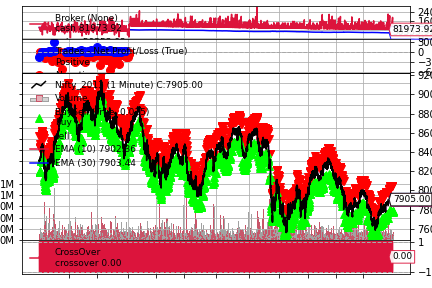

[[<Figure size 432x288 with 5 Axes>]]

In [12]:
cerebro.plot()
#Observe that a lot more green and red markers for buying and selling respectively
#Even at the points where there is no crossover whatsoever, and looks like the buy and sell signs are executed also

In [15]:
#The analysing ratios and graphs
#Get the first strategy, in backtrader the analysing is done for each individual sttrategy
strat = strats[0]

#Pyfolio is the default name given by backtrader, check how to give a custom name
pyfoliozer = strat.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()

pf.create_full_tear_sheet(
    returns,
    positions=positions,
    transactions=transactions,
    live_start_date=datetime.datetime(2015,6,5))


IndexError: index -1 is out of bounds for axis 0 with size 0